2024-06-26 21:57:47.921140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 21:57:48.827890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


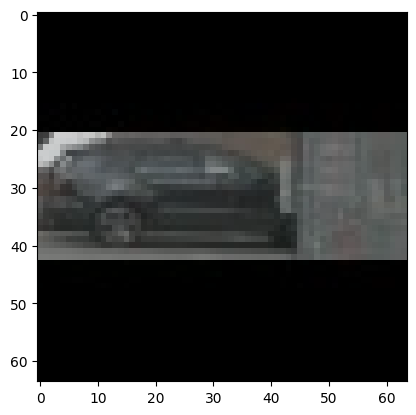

dist length 64
3D:, [9.882782967928245, 0.6162751503425804, 21.242949111578312, 2.38, 5.335, 1.975, 1.5873838004614682, 0.2442912660256097, -0.018645116723832844] 2D [0.7736876075589296, 1.0, 0.4937582647364166, 0.6352478383867766] dist [ 9.48069286 20.50186729 20.39664841 20.81233788 24.95669174 20.77006149
 12.02354622  8.10935974 30.16394806 28.39368248 20.57725334 23.96767044
 29.90968895 20.34169769 24.16835022 29.8526001  20.81775856 20.7317276
 11.32740021 25.00743103  9.72262764 29.47467041 20.6274147  28.7731266
  9.66766739 20.54515457 11.41732597 28.65410995 20.85127831 21.2287178
 29.79626274  9.91371632 20.80700493 23.83758926 29.29081917 30.03705788
 28.3277092  29.97480392 24.17492104 23.79183578 20.48398399 20.68766975
  7.3106389  20.80363655 20.65101051 20.99132156 20.34386444  9.70662975
 28.58721352  8.43681717 30.10194778 24.28627777 20.77975082 21.17471313
 28.45364189  7.28163528  8.04972458 29.60042763 10.29885674 20.90049553
 23.7621479   8.20612144  7.50452757

In [1]:
import os
from collections import defaultdict
import numpy as np
import math
import cv2
from pyquaternion import Quaternion
from tensorflow.keras.utils import Sequence
import json

def save_normalization_stats(file_path, normalization_stats):
    stats_dict = {
        'distances_mean': normalization_stats[0],
        'distances_std': normalization_stats[1],
        'centers_x_mean': normalization_stats[2],
        'centers_x_std': normalization_stats[3],
        'centers_y_mean': normalization_stats[4],
        'centers_y_std': normalization_stats[5],
        'centers_z_mean': normalization_stats[6],
        'centers_z_std': normalization_stats[7],
        'sizes_x_mean': normalization_stats[8],
        'sizes_x_std': normalization_stats[9],
        'sizes_y_mean': normalization_stats[10],
        'sizes_y_std': normalization_stats[11],
        'sizes_z_mean': normalization_stats[12],
        'sizes_z_std': normalization_stats[13],
        'euler_angles_roll_mean': normalization_stats[14],
        'euler_angles_roll_std': normalization_stats[15],
        'euler_angles_pitch_mean': normalization_stats[16],
        'euler_angles_pitch_std': normalization_stats[17],
        'euler_angles_yaw_mean': normalization_stats[18],
        'euler_angles_yaw_std': normalization_stats[19],
    }
    with open(file_path, 'w') as file:
        json.dump(stats_dict, file)
        
# Function to calculate mean and std values for normalization
def calculate_mean_std(values):
    mean_val = np.mean(values)
    std_val = np.std(values)
    return mean_val, std_val

# Function to normalize values using mean and std
def standardize(values, mean_val, std_val):
    return (values - mean_val) / std_val

def normalize(values, min, max):
    return (values - min) / (max - min)


def get_quaternion_from_euler(roll, pitch, yaw):
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    return [qx, qy, qz, qw]

def quaternion_to_euler(w, x, y, z):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(t3, t4)
    return [roll, pitch, yaw]



import os
import json
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor
import os
import json
import numpy as np
import cv2

def load_samples(dataset):
    image_files = []
    distance_files = []
    metadata_files = []

    with os.scandir(dataset) as it:
        for entry in it:
            if entry.is_file():
                filename = entry.name
                if filename.endswith('.jpg'):
                    image_files.append(filename)
                elif filename.endswith('.npy') and filename.startswith('distances'):
                    distance_files.append(filename)
                elif filename.endswith('.json'):
                    metadata_files.append(filename)

    return image_files, distance_files, metadata_files

def extract_info_from_filename(filename):
    parts = os.path.basename(filename).replace('.json', '').replace('.npy', '').replace('.jpg', '').split('_')
    if filename.endswith('.jpg'):
        sample_number = int(parts[3])
        index = int(parts[-1])
        camera_name_parts = parts[5:-1]
    elif filename.endswith(".npy"):
        sample_number = int(parts[2])
        index = int(parts[-1])
        camera_name_parts = parts[4:-1]
    elif filename.endswith(".json"):
        sample_number = int(parts[3])
        index = None
        camera_name_parts = parts[5:]

    camera_name = '_'.join(camera_name_parts)

    return sample_number, camera_name, index

def get_file_mapping(image_files, distance_files, metadata_files):
    file_mapping = []

    metadata_dict = {}
    for filename in metadata_files:
        sample_number, camera_name, _ = extract_info_from_filename(filename)
        if camera_name == "CAM_BACK":
            continue
        metadata_dict[(sample_number, camera_name)] = filename

    #print('metadata dict done')
    distance_dict = {}
    for filename in distance_files:
        sample_number, camera_name, index = extract_info_from_filename(filename)
        if camera_name == "CAM_BACK":
            print('cam back')
            continue
        distance_dict[(sample_number, camera_name, index)] = filename
    
    #print('distance dict done')

    for image_file in image_files:
        sample_number, camera_name, index = extract_info_from_filename(image_file)
        if camera_name == "CAM_BACK":
            continue
        metadata_file = metadata_dict.get((sample_number, camera_name))
        if not metadata_file:
            continue
        distance_file = distance_dict.get((sample_number, camera_name, index))

        file_mapping.append({
            'sample_number': sample_number,
            'image_file': image_file,
            'distance_file': distance_file,
            'metadata_file': metadata_file,
            'index': index
        })
    #print('file mapping done')

    return file_mapping

def read_metadata_and_get_names(metadata_file, directory='/home/nuno120/Documents/SCRIPTIE/3DBOXESDIRECTLIDAR'):
    
    metadata_file = os.path.join(directory, metadata_file)
    if not os.path.exists(metadata_file):
        raise FileNotFoundError(f"The file {metadata_file} does not exist.")
    
    with open(metadata_file, 'r') as f:
        data = json.load(f)
    
    names = [obj['Object Name'] for obj in data]
    return names


def read_metadata_and_get_data(metadata_file, image_width=1600, image_height=900, directory='/home/nuno120/Documents/SCRIPTIE/3DBOXESDIRECTLIDAR'):
    metadata_file = os.path.join(directory, metadata_file)
    if not os.path.exists(metadata_file):
        raise FileNotFoundError(f"The file {metadata_file} does not exist.")
    
    with open(metadata_file, 'r') as f:
        data = json.load(f)

    threeD_boxes = []
    twoD_boxes = []
    indexxes = []
    names = []

    for i, obj in enumerate(data):
        center = obj['Center']
        size = obj['Size']
        euler_orientation = obj['Euler Orientation']
        name = obj['Object Name']
        names.append(name)

        threeD_box = center + size + euler_orientation
        threeD_boxes.append(threeD_box)

        y_min, y_max, x_min, x_max = obj['2D box']
        x_min = x_min / image_width
        x_max = x_max / image_width
        y_min = y_min / image_height
        y_max = y_max / image_height
        twoD_box = [x_min, x_max, y_min, y_max]
        twoD_boxes.append(twoD_box)

        indexxes.append(i)

    return threeD_boxes, twoD_boxes, indexxes, names

def get_total_list_sample_camera_index(path= '/home/nuno120/Documents/SCRIPTIE/3DBOXESDIRECTLIDAR'):
    image_files, distance_files, metadata_files = load_samples(path)
    #print('load samples done')
    file_mapping = get_file_mapping(image_files, distance_files, metadata_files)
    #$print('file mapping done')
    
    
    for entry in file_mapping:
        metadata_file = entry['metadata_file']
        index = entry['index']
        names = read_metadata_and_get_names(metadata_file)
        entry['object_name'] = names[index] if index is not None and index < len(names) else None

    #print('done adding the names to the file mapping')
    return file_mapping

def filter_total_list_samples(file_mapping, specific_classes=['vehicle.car']):
    filtered_sample_list = [entry for entry in file_mapping if entry['object_name'] in specific_classes]
    return filtered_sample_list

def get_single_item(file_mapping, index_in_total_list, directory='/home/nuno120/Documents/SCRIPTIE/3DBOXESDIRECTLIDAR'):
    entry = file_mapping[index_in_total_list]
    metadata_file = entry['metadata_file']
    distance_file = entry['distance_file']
    #print("dist file", distance_file)
    image_file = entry['image_file']
    index = entry['index']
    
    metadata_file = os.path.join(directory, metadata_file)
    distance_file = os.path.join(directory, distance_file)
    image_file = os.path.join(directory, image_file)
    
    threeD_boxes, twoD_boxes, _, names = read_metadata_and_get_data(metadata_file)
    threeD_box = threeD_boxes[index]
    distance_center = np.sqrt(threeD_box[0]**2 + threeD_box[1]**2 + threeD_box[2]**2)
    if distance_center > 40:
        threeD_box = [0 for x in range(len(threeD_box))]
    twoD_box = twoD_boxes[index]
    distance = np.load(distance_file)
    image = cv2.imread(image_file)
    #normalize the image by dividing by 255
    image = image / 255
    name = names[index]

    return threeD_box, twoD_box, distance, image, name

# Example usage
path = '/home/nuno120/Documents/SCRIPTIE/3DBOXESDIRECTLIDAR'
file_mapping = get_total_list_sample_camera_index(path)

#print('done getting total list')
#print('file mapping:', file_mapping)
filtered_sample_list = filter_total_list_samples(file_mapping, specific_classes=['vehicle.car'
                                                                                 ])
index_in_filtered_sample_list = 1
threeD_box, twoD_box, distance, image, name = get_single_item(filtered_sample_list, index_in_filtered_sample_list)
#shoe thr image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()
print('dist length', len(distance))
print('3D:,', threeD_box, '2D', twoD_box, 'dist', distance, image, name)




[ 1.5873838   1.5873838  -1.56534814 ...  0.          0.
 -1.56534814]
all y min [0.49375826 0.49375826 0.53114771 ... 0.54369235 0.5349969  0.53114771]


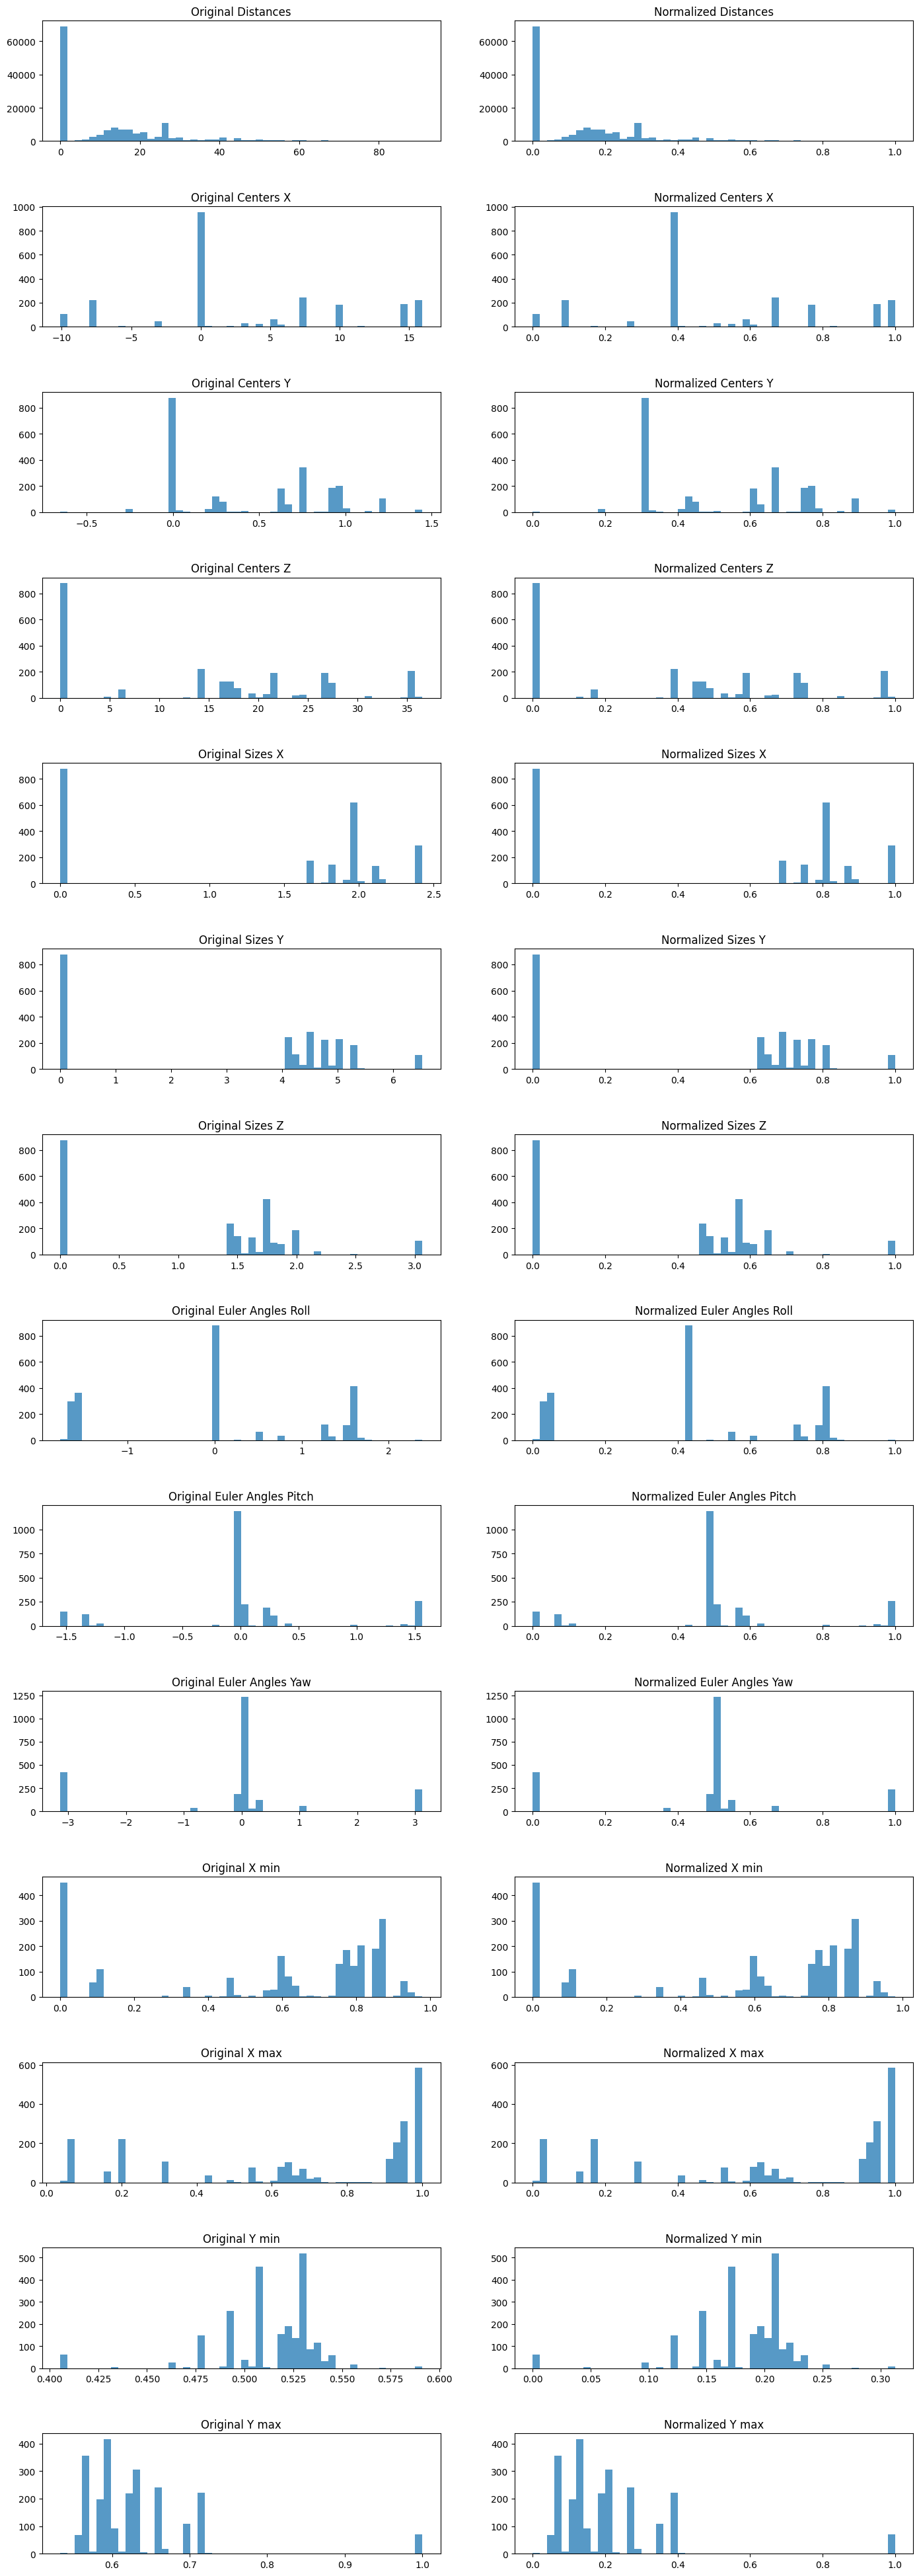

(0.0, 90.9238052368164, -10.117409217583985, 15.942095885742257, -0.6545319915535477, 1.4464012048127086, 0.0, 36.52748216243165, 0.0, 2.424, 0.0, 6.524, 0.0, 3.065, -1.7750100250035672, 2.386063751351525, -1.5524252315050315, 1.564955952085275, -3.137081230952921, 3.1285522059332207)
Loaded normalization stats: (0.0, 97.31453704833984, -19.513547845002464, 18.51670869710173, -1.3300511182498824, 2.254118812666424, 0.0, 45.907078658442124, 0.0, 2.62, 0.0, 5.606, 0.0, 2.988, -1.5881427665159953, 2.9906140417668787, -1.5670488434350485, 1.56084249378007, -3.139661839409377, 3.140293924682609)
Example batch: ({'image_input': array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0. 

In [24]:
def calculate_normalization_stats(file_mapping, directory):
    all_distances = []
    all_centers_x = []
    all_centers_y = []
    all_centers_z = []
    all_sizes_x = []
    all_sizes_y = []
    all_sizes_z = []
    all_euler_angles_roll = []
    all_euler_angles_pitch = []
    all_euler_angles_yaw = []
    all_x_min = []
    all_x_max = []
    all_y_min = []
    all_y_max = []

    for entry in file_mapping:
        threeD_box, twoD_box, distance, image, name = get_single_item(file_mapping, entry['index'], directory)

        all_distances.extend(distance.flatten())


        all_centers_x.append(threeD_box[0])
        all_centers_y.append(threeD_box[1])
        all_centers_z.append(threeD_box[2])
        all_sizes_x.append(threeD_box[3])
        all_sizes_y.append(threeD_box[4])
        all_sizes_z.append(threeD_box[5])
        all_euler_angles_roll.append(threeD_box[6])
        all_euler_angles_pitch.append(threeD_box[7])
        all_euler_angles_yaw.append(threeD_box[8])
        all_x_min.append(twoD_box[0])
        all_x_max.append(twoD_box[1])
        all_y_min.append(twoD_box[2])
        all_y_max.append(twoD_box[3])

    # Convert lists to numpy arrays for easier processing
    all_distances = np.array(all_distances)
    all_centers_x = np.array(all_centers_x)
    all_centers_y = np.array(all_centers_y)
    all_centers_z = np.array(all_centers_z)
    all_sizes_x = np.array(all_sizes_x)
    all_sizes_y = np.array(all_sizes_y)
    all_sizes_z = np.array(all_sizes_z)
    all_euler_angles_roll = np.array(all_euler_angles_roll)
    all_euler_angles_pitch = np.array(all_euler_angles_pitch)
    all_euler_angles_yaw = np.array(all_euler_angles_yaw)
    print(all_euler_angles_roll)
    all_x_min = np.array(all_x_min)
    all_x_max = np.array(all_x_max)
    all_y_min = np.array(all_y_min)
    print('all y min', all_y_min)
    all_y_max = np.array(all_y_max)


    # Calculate min and max values
    distances_min, distances_max = np.min(all_distances), np.max(all_distances)
    centers_x_min, centers_x_max = np.min(all_centers_x), np.max(all_centers_x)
    centers_y_min, centers_y_max = np.min(all_centers_y), np.max(all_centers_y)
    centers_z_min, centers_z_max = np.min(all_centers_z), np.max(all_centers_z)
    sizes_x_min, sizes_x_max = np.min(all_sizes_x), np.max(all_sizes_x)
    sizes_y_min, sizes_y_max = np.min(all_sizes_y), np.max(all_sizes_y)
    sizes_z_min, sizes_z_max = np.min(all_sizes_z), np.max(all_sizes_z)
    euler_angles_roll_min, euler_angles_roll_max = np.min(all_euler_angles_roll), np.max(all_euler_angles_roll)
    euler_angles_pitch_min, euler_angles_pitch_max = np.min(all_euler_angles_pitch), np.max(all_euler_angles_pitch)
    euler_angles_yaw_min, euler_angles_yaw_max = np.min(all_euler_angles_yaw), np.max(all_euler_angles_yaw)
    all_x_min_min, all_x_max_max = np.min(all_x_min), np.max(all_x_max)
    all_y_min_min, all_y_max_max = np.min(all_y_min), np.max(all_y_max)
    all_x_max_min, all_x_max_max = np.min(all_x_max), np.max(all_x_max)
    all_y_max_min, all_y_max_max = np.min(all_y_max), np.max(all_y_max)

    


    # Normalize the data
    normalized_distances = (all_distances - distances_min) / (distances_max - distances_min)
    normalized_centers_x = (all_centers_x - centers_x_min) / (centers_x_max - centers_x_min)
    normalized_centers_y = (all_centers_y - centers_y_min) / (centers_y_max - centers_y_min)
    normalized_centers_z = (all_centers_z - centers_z_min) / (centers_z_max - centers_z_min)
    normalized_sizes_x = (all_sizes_x - sizes_x_min) / (sizes_x_max - sizes_x_min)
    normalized_sizes_y = (all_sizes_y - sizes_y_min) / (sizes_y_max - sizes_y_min)
    normalized_sizes_z = (all_sizes_z - sizes_z_min) / (sizes_z_max - sizes_z_min)
    normalized_euler_angles_roll = (all_euler_angles_roll - euler_angles_roll_min) / (euler_angles_roll_max - euler_angles_roll_min)
    normalized_euler_angles_pitch = (all_euler_angles_pitch - euler_angles_pitch_min) / (euler_angles_pitch_max - euler_angles_pitch_min)
    normalized_euler_angles_yaw = (all_euler_angles_yaw - euler_angles_yaw_min) / (euler_angles_yaw_max - euler_angles_yaw_min)
    normalized_x_min = (all_x_min - all_x_min_min) / (all_x_max_max - all_x_min_min)
    normalized_x_max = (all_x_max - all_x_max_min) / (all_x_max_max - all_x_max_min)
    normalized_y_min = (all_y_min - all_y_min_min) / (all_y_max_max - all_y_min_min)
    normalized_y_max = (all_y_max - all_y_max_min) / (all_y_max_max - all_y_max_min)




    data_to_plot = {
        "Distances": (all_distances, normalized_distances),
        "Centers X": (all_centers_x, normalized_centers_x),
        "Centers Y": (all_centers_y, normalized_centers_y),
        "Centers Z": (all_centers_z, normalized_centers_z),
        "Sizes X": (all_sizes_x, normalized_sizes_x),
        "Sizes Y": (all_sizes_y, normalized_sizes_y),
        "Sizes Z": (all_sizes_z, normalized_sizes_z),
        "Euler Angles Roll": (all_euler_angles_roll, normalized_euler_angles_roll),
        "Euler Angles Pitch": (all_euler_angles_pitch, normalized_euler_angles_pitch),
        "Euler Angles Yaw": (all_euler_angles_yaw, normalized_euler_angles_yaw),
        "X min": (all_x_min, normalized_x_min),
        "X max": (all_x_max, normalized_x_max),
        "Y min": (all_y_min, normalized_y_min),
        "Y max": (all_y_max, normalized_y_max)
    }

    fig, axes = plt.subplots(nrows=14, ncols=2, figsize=(15, 40))
    fig.tight_layout(pad=5.0)

    for idx, (title, (original_data, normalized_data)) in enumerate(data_to_plot.items()):
        row = idx
        axes[row, 0].hist(original_data, bins=50, alpha=0.75)
        axes[row, 0].set_title(f'Original {title}')
        axes[row, 1].hist(normalized_data, bins=50, alpha=0.75)
        axes[row, 1].set_title(f'Normalized {title}')

    plt.show()

    normalization_stats = (
        distances_min, distances_max,
        centers_x_min, centers_x_max,
        centers_y_min, centers_y_max,
        centers_z_min, centers_z_max,
        sizes_x_min, sizes_x_max,
        sizes_y_min, sizes_y_max,
        sizes_z_min, sizes_z_max,
        euler_angles_roll_min, euler_angles_roll_max,
        euler_angles_pitch_min, euler_angles_pitch_max,
        euler_angles_yaw_min, euler_angles_yaw_max,
    )

    return normalization_stats

def save_normalization_stats(filepath, normalization_stats):
    normalization_dict = {
        "distances_min": normalization_stats[0],
        "distances_max": normalization_stats[1],
        "centers_x_min": normalization_stats[2],
        "centers_x_max": normalization_stats[3],
        "centers_y_min": normalization_stats[4],
        "centers_y_max": normalization_stats[5],
        "centers_z_min": normalization_stats[6],
        "centers_z_max": normalization_stats[7],
        "sizes_x_min": normalization_stats[8],
        "sizes_x_max": normalization_stats[9],
        "sizes_y_min": normalization_stats[10],
        "sizes_y_max": normalization_stats[11],
        "sizes_z_min": normalization_stats[12],
        "sizes_z_max": normalization_stats[13],
        "euler_angles_roll_min": normalization_stats[14],
        "euler_angles_roll_max": normalization_stats[15],
        "euler_angles_pitch_min": normalization_stats[16],
        "euler_angles_pitch_max": normalization_stats[17],
        "euler_angles_yaw_min": normalization_stats[18],
        "euler_angles_yaw_max": normalization_stats[19],
    }
    normalization_dict = {k: float(v) for k, v in normalization_dict.items()}

    with open(filepath, 'w') as f:
        json.dump(normalization_dict, f)

def load_normalization_stats(filepath):
    with open(filepath, 'r') as f:
        normalization_dict = json.load(f)
    
    normalization_stats = (
        normalization_dict["distances_min"], normalization_dict["distances_max"],
        normalization_dict["centers_x_min"], normalization_dict["centers_x_max"],
        normalization_dict["centers_y_min"], normalization_dict["centers_y_max"],
        normalization_dict["centers_z_min"], normalization_dict["centers_z_max"],
        normalization_dict["sizes_x_min"], normalization_dict["sizes_x_max"],
        normalization_dict["sizes_y_min"], normalization_dict["sizes_y_max"],
        normalization_dict["sizes_z_min"], normalization_dict["sizes_z_max"],
        normalization_dict["euler_angles_roll_min"], normalization_dict["euler_angles_roll_max"],
        normalization_dict["euler_angles_pitch_min"], normalization_dict["euler_angles_pitch_max"],
        normalization_dict["euler_angles_yaw_min"], normalization_dict["euler_angles_yaw_max"],

    )
    
    return normalization_stats

class DataGenerator(Sequence):
    def __init__(self, file_mapping, batch_size, normalization_stats, directory, gray=False):
        self.file_mapping = file_mapping
        self.batch_size = batch_size
        self.directory = directory
        self.distances_min, self.distances_max, \
        self.centers_x_min, self.centers_x_max, self.centers_y_min, self.centers_y_max, self.centers_z_min, self.centers_z_max, \
        self.sizes_x_min, self.sizes_x_max, self.sizes_y_min, self.sizes_y_max, self.sizes_z_min, self.sizes_z_max, \
        self.euler_angles_roll_min, self.euler_angles_roll_max, self.euler_angles_pitch_min, self.euler_angles_pitch_max, self.euler_angles_yaw_min, self.euler_angles_yaw_max = normalization_stats
        self.gray = gray
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_mapping) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        batch_file_mapping = self.file_mapping[start_index:end_index]

        images, distances, boxes_2D, boxes_3D = self.__data_generation(batch_file_mapping)

        return {'image_input': images, 'distances_input': distances, 'box_2D_input':boxes_2D }, boxes_3D

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_mapping))
        np.random.shuffle(self.indexes)
        self.file_mapping = [self.file_mapping[i] for i in self.indexes]

    def __data_generation(self, batch_file_mapping):
        images = np.zeros((self.batch_size, 64, 64, 1 if self.gray else 3))
        distances = np.zeros((self.batch_size, 64))
        boxes_2D = np.zeros((self.batch_size, 4))
        boxes_3D = np.zeros((self.batch_size, 9))

        for i, entry in enumerate(batch_file_mapping):
            threeD_box, twoD_box, distance, image, _ = get_single_item(self.file_mapping, i, self.directory)
            if self.gray:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = np.expand_dims(image, axis=-1)
            images[i,] = image
            #distances[i,] = self.normalize(distance, self.distances_min, self.distances_max)
            distances[i,] = distance
            boxes_2D[i,] = twoD_box
            boxes_3D[i,] = threeD_box
            #boxes_3D[i,0] = self.normalize(threeD_box[0], self.centers_x_min, self.centers_x_max)
            #boxes_3D[i,1] = self.normalize(threeD_box[1], self.centers_y_min, self.centers_y_max)
            #boxes_3D[i,2] = self.normalize(threeD_box[2], self.centers_z_min, self.centers_z_max)
            #boxes_3D[i,3] = self.normalize(threeD_box[3], self.sizes_x_min, self.sizes_x_max)
            #boxes_3D[i,4] = self.normalize(threeD_box[4], self.sizes_y_min, self.sizes_y_max)
            #boxes_3D[i,5] = self.normalize(threeD_box[5], self.sizes_z_min, self.sizes_z_max)
            #boxes_3D[i,6] = self.normalize(threeD_box[6], self.euler_angles_roll_min, self.euler_angles_roll_max)
            #boxes_3D[i,7] = self.normalize(threeD_box[7], self.euler_angles_pitch_min, self.euler_angles_pitch_max)
            #boxes_3D[i,8] = self.normalize(threeD_box[8], self.euler_angles_yaw_min, self.euler_angles_yaw_max)

        return images, distances, boxes_2D, boxes_3D

    def normalize(self, value, min_val, max_val):
        return (value - min_val) / (max_val - min_val)


path = '/home/nuno120/Documents/SCRIPTIE/3DBOXESDIRECTLIDAR'
file_mapping = get_total_list_sample_camera_index(path)
filtered_sample_list = filter_total_list_samples(file_mapping, specific_classes=['vehicle.car'])

# Calculate normalization stats
normalization_stats = calculate_normalization_stats(filtered_sample_list, path)
print(normalization_stats)
# Save normalization stats to a JSON file
#save_normalization_stats('/home/nuno120/Documents/SCRIPTIE/normalization_stats_car.json', normalization_stats)

# Load normalization stats from a JSON file
loaded_normalization_stats = load_normalization_stats('/home/nuno120/Documents/SCRIPTIE/normalization_stats_car.json')

print('Loaded normalization stats:', loaded_normalization_stats)


batch_size = 256
#create the val and train generator

data_generator_train = DataGenerator(filtered_sample_list[:int(0.8* len(filtered_sample_list[8:]))], batch_size, loaded_normalization_stats, path, gray=False)
data_generator_val = DataGenerator(filtered_sample_list[int(0.8* len(filtered_sample_list[8:])):],batch_size, loaded_normalization_stats, path, gray=False )
# Example of getting a batch
example_batch = data_generator_train[0]
print('Example batch:', example_batch)


In [31]:
"""import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt
def calculate_normalization_stats(file_mapping, directory):
    all_distances = []
    all_centers_x = []
    all_centers_y = []
    all_centers_z = []
    all_sizes_x = []
    all_sizes_y = []
    all_sizes_z = []
    all_euler_angles_roll = []
    all_euler_angles_pitch = []
    all_euler_angles_yaw = []

    for entry in file_mapping:
        threeD_box, twoD_box, distance, image, name = get_single_item(file_mapping, entry['index'], directory)
        all_distances.extend(distance.flatten())

        all_centers_x.append(threeD_box[0])
        all_centers_y.append(threeD_box[1])
        all_centers_z.append(threeD_box[2])
        all_sizes_x.append(threeD_box[3])
        all_sizes_y.append(threeD_box[4])
        all_sizes_z.append(threeD_box[5])
        all_euler_angles_roll.append(threeD_box[6])
        all_euler_angles_pitch.append(threeD_box[7])
        all_euler_angles_yaw.append(threeD_box[8])

    # Convert lists to numpy arrays for easier processing
    all_distances = np.array(all_distances)
    all_centers_x = np.array(all_centers_x)
    all_centers_y = np.array(all_centers_y)
    all_centers_z = np.array(all_centers_z)
    all_sizes_x = np.array(all_sizes_x)
    all_sizes_y = np.array(all_sizes_y)
    all_sizes_z = np.array(all_sizes_z)
    all_euler_angles_roll = np.array(all_euler_angles_roll)
    all_euler_angles_pitch = np.array(all_euler_angles_pitch)
    all_euler_angles_yaw = np.array(all_euler_angles_yaw)

    # Exclude zeros from distances for normalization
    non_zero_distances = all_distances[all_distances != 0]

    # Calculate means and standard deviations
    distances_mean, distances_std = np.mean(non_zero_distances), np.std(non_zero_distances)
    centers_x_mean, centers_x_std = np.mean(all_centers_x), np.std(all_centers_x)
    centers_y_mean, centers_y_std = np.mean(all_centers_y), np.std(all_centers_y)
    centers_z_mean, centers_z_std = np.mean(all_centers_z), np.std(all_centers_z)
    sizes_x_mean, sizes_x_std = np.mean(all_sizes_x), np.std(all_sizes_x)
    sizes_y_mean, sizes_y_std = np.mean(all_sizes_y), np.std(all_sizes_y)
    sizes_z_mean, sizes_z_std = np.mean(all_sizes_z), np.std(all_sizes_z)
    euler_angles_roll_mean, euler_angles_roll_std = np.mean(all_euler_angles_roll), np.std(all_euler_angles_roll)
    euler_angles_pitch_mean, euler_angles_pitch_std = np.mean(all_euler_angles_pitch), np.std(all_euler_angles_pitch)
    euler_angles_yaw_mean, euler_angles_yaw_std = np.mean(all_euler_angles_yaw), np.std(all_euler_angles_yaw)

    # Normalize the data
    normalized_distances = (non_zero_distances - distances_mean) / distances_std
    normalized_centers_x = (all_centers_x - centers_x_mean) / centers_x_std
    normalized_centers_y = (all_centers_y - centers_y_mean) / centers_y_std
    normalized_centers_z = (all_centers_z - centers_z_mean) / centers_z_std
    normalized_sizes_x = (all_sizes_x - sizes_x_mean) / sizes_x_std
    normalized_sizes_y = (all_sizes_y - sizes_y_mean) / sizes_y_std
    normalized_sizes_z = (all_sizes_z - sizes_z_mean) / sizes_z_std
    normalized_euler_angles_roll = (all_euler_angles_roll - euler_angles_roll_mean) / euler_angles_roll_std
    normalized_euler_angles_pitch = (all_euler_angles_pitch - euler_angles_pitch_mean) / euler_angles_pitch_std
    normalized_euler_angles_yaw = (all_euler_angles_yaw - euler_angles_yaw_mean) / euler_angles_yaw_std

    # Plotting distributions
    data_to_plot = {
        "Distances": (non_zero_distances, normalized_distances),
        "Centers X": (all_centers_x, normalized_centers_x),
        "Centers Y": (all_centers_y, normalized_centers_y),
        "Centers Z": (all_centers_z, normalized_centers_z),
        "Sizes X": (all_sizes_x, normalized_sizes_x),
        "Sizes Y": (all_sizes_y, normalized_sizes_y),
        "Sizes Z": (all_sizes_z, normalized_sizes_z),
        "Euler Angles Roll": (all_euler_angles_roll, normalized_euler_angles_roll),
        "Euler Angles Pitch": (all_euler_angles_pitch, normalized_euler_angles_pitch),
        "Euler Angles Yaw": (all_euler_angles_yaw, normalized_euler_angles_yaw)
    }

    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 40))
    fig.tight_layout(pad=5.0)

    for idx, (title, (original_data, normalized_data)) in enumerate(data_to_plot.items()):
        row = idx
        axes[row, 0].hist(original_data, bins=50, alpha=0.75)
        axes[row, 0].set_title(f'Original {title}')
        axes[row, 1].hist(normalized_data, bins=50, alpha=0.75)
        axes[row, 1].set_title(f'Normalized {title}')

    plt.show()

    normalization_stats = (
        distances_mean, distances_std,
        centers_x_mean, centers_x_std,
        centers_y_mean, centers_y_std,
        centers_z_mean, centers_z_std,
        sizes_x_mean, sizes_x_std,
        sizes_y_mean, sizes_y_std,
        sizes_z_mean, sizes_z_std,
        euler_angles_roll_mean, euler_angles_roll_std,
        euler_angles_pitch_mean, euler_angles_pitch_std,
        euler_angles_yaw_mean, euler_angles_yaw_std
    )

    return normalization_stats


def save_normalization_stats(filepath, normalization_stats):
    normalization_dict = {
        "distances_mean": normalization_stats[0],
        "distances_std": normalization_stats[1],
        "centers_x_mean": normalization_stats[2],
        "centers_x_std": normalization_stats[3],
        "centers_y_mean": normalization_stats[4],
        "centers_y_std": normalization_stats[5],
        "centers_z_mean": normalization_stats[6],
        "centers_z_std": normalization_stats[7],
        "sizes_x_mean": normalization_stats[8],
        "sizes_x_std": normalization_stats[9],
        "sizes_y_mean": normalization_stats[10],
        "sizes_y_std": normalization_stats[11],
        "sizes_z_mean": normalization_stats[12],
        "sizes_z_std": normalization_stats[13],
        "euler_angles_roll_mean": normalization_stats[14],
        "euler_angles_roll_std": normalization_stats[15],
        "euler_angles_pitch_mean": normalization_stats[16],
        "euler_angles_pitch_std": normalization_stats[17],
        "euler_angles_yaw_mean": normalization_stats[18],
        "euler_angles_yaw_std": normalization_stats[19],
    }
    normalization_dict = {k: float(v) for k, v in normalization_dict.items()}

    with open(filepath, 'w') as f:
        json.dump(normalization_dict, f)

def load_normalization_stats(filepath):
    with open(filepath, 'r') as f:
        normalization_dict = json.load(f)
    
    normalization_stats = (
        normalization_dict["distances_mean"], normalization_dict["distances_std"],
        normalization_dict["centers_x_mean"], normalization_dict["centers_x_std"],
        normalization_dict["centers_y_mean"], normalization_dict["centers_y_std"],
        normalization_dict["centers_z_mean"], normalization_dict["centers_z_std"],
        normalization_dict["sizes_x_mean"], normalization_dict["sizes_x_std"],
        normalization_dict["sizes_y_mean"], normalization_dict["sizes_y_std"],
        normalization_dict["sizes_z_mean"], normalization_dict["sizes_z_std"],
        normalization_dict["euler_angles_roll_mean"], normalization_dict["euler_angles_roll_std"],
        normalization_dict["euler_angles_pitch_mean"], normalization_dict["euler_angles_pitch_std"],
        normalization_dict["euler_angles_yaw_mean"], normalization_dict["euler_angles_yaw_std"]
    )
    
    return normalization_stats



from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, file_mapping, batch_size, normalization_stats, directory, gray=False):
        self.file_mapping = file_mapping
        self.batch_size = batch_size
        self.directory = directory
        self.distances_mean, self.distances_std, \
        self.centers_x_mean, self.centers_x_std, self.centers_y_mean, self.centers_y_std, self.centers_z_mean, self.centers_z_std, \
        self.sizes_x_mean, self.sizes_x_std, self.sizes_y_mean, self.sizes_y_std, self.sizes_z_mean, self.sizes_z_std, \
        self.euler_angles_roll_mean, self.euler_angles_roll_std, self.euler_angles_pitch_mean, self.euler_angles_pitch_std, self.euler_angles_yaw_mean, self.euler_angles_yaw_std = normalization_stats
        self.gray = gray
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_mapping) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        batch_file_mapping = self.file_mapping[start_index:end_index]

        images, distances, boxes_2D, boxes_3D = self.__data_generation(batch_file_mapping)

        return {'image_input': images, 'distances_input': distances, 'box_2D_input': boxes_2D}, boxes_3D

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_mapping))
        np.random.shuffle(self.indexes)
        self.file_mapping = [self.file_mapping[i] for i in self.indexes]

    def __data_generation(self, batch_file_mapping):
        images = np.zeros((self.batch_size, 64, 64, 1 if self.gray else 3))
        distances = np.zeros((self.batch_size, 256))
        boxes_2D = np.zeros((self.batch_size, 4))
        boxes_3D = np.zeros((self.batch_size, 9))

        for i, entry in enumerate(batch_file_mapping):
            threeD_box, twoD_box, distance, image, _ = get_single_item(self.file_mapping, i, self.directory)
            #print('distance single item, ', distance)
            if self.gray:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = np.expand_dims(image, axis=-1)
            images[i,] = image
            distances[i,] = self.normalize(distance, self.distances_mean, self.distances_std)
            boxes_2D[i,] = twoD_box
            boxes_3D[i,0] = self.normalize(threeD_box[0], self.centers_x_mean, self.centers_x_std)
            boxes_3D[i,1] = self.normalize(threeD_box[1], self.centers_y_mean, self.centers_y_std)
            boxes_3D[i,2] = self.normalize(threeD_box[2], self.centers_z_mean, self.centers_z_std)
            boxes_3D[i,3] = self.normalize(threeD_box[3], self.sizes_x_mean, self.sizes_x_std)
            boxes_3D[i,4] = self.normalize(threeD_box[4], self.sizes_y_mean, self.sizes_y_std)
            boxes_3D[i,5] = self.normalize(threeD_box[5], self.sizes_z_mean, self.sizes_z_std)
            boxes_3D[i,6] = self.normalize(threeD_box[6], self.euler_angles_roll_mean, self.euler_angles_roll_std)
            boxes_3D[i,7] = self.normalize(threeD_box[7], self.euler_angles_pitch_mean, self.euler_angles_pitch_std)
            boxes_3D[i,8] = self.normalize(threeD_box[8], self.euler_angles_yaw_mean, self.euler_angles_yaw_std)

        return images, distances, boxes_2D, boxes_3D

    def normalize(self, value, mean, std):
        return (value - mean) / std

# Example usage
path = '/home/nuno120/Documents/SCRIPTIE/3DBOXES2'
file_mapping = get_total_list_sample_camera_index(path)
filtered_sample_list = filter_total_list_samples(file_mapping, specific_classes=['vehicle.car'])

# Calculate normalization stats
normalization_stats = calculate_normalization_stats(filtered_sample_list, path)
print(normalization_stats)
# Save normalization stats to a JSON file
save_normalization_stats('/home/nuno120/Documents/SCRIPTIE/normalization_stats_car.json', normalization_stats)

# Load normalization stats from a JSON file
loaded_normalization_stats = load_normalization_stats('/home/nuno120/Documents/SCRIPTIE/normalization_stats_car.json')

print('Loaded normalization stats:', loaded_normalization_stats)


batch_size = 32
#create the val and train generator

data_generator_train = DataGenerator(filtered_sample_list[:int(0.8* len(filtered_sample_list[8:]))], batch_size, loaded_normalization_stats, path, gray=False)
data_generator_val = DataGenerator(filtered_sample_list[int(0.8* len(filtered_sample_list[8:])):],batch_size, loaded_normalization_stats, path, gray=False )
# Example of getting a batch
example_batch = data_generator_train[0]
print('Example batch:', example_batch)"""

'import numpy as np\nimport json\nimport numpy as np\nimport matplotlib.pyplot as plt\ndef calculate_normalization_stats(file_mapping, directory):\n    all_distances = []\n    all_centers_x = []\n    all_centers_y = []\n    all_centers_z = []\n    all_sizes_x = []\n    all_sizes_y = []\n    all_sizes_z = []\n    all_euler_angles_roll = []\n    all_euler_angles_pitch = []\n    all_euler_angles_yaw = []\n\n    for entry in file_mapping:\n        threeD_box, twoD_box, distance, image, name = get_single_item(file_mapping, entry[\'index\'], directory)\n        all_distances.extend(distance.flatten())\n\n        all_centers_x.append(threeD_box[0])\n        all_centers_y.append(threeD_box[1])\n        all_centers_z.append(threeD_box[2])\n        all_sizes_x.append(threeD_box[3])\n        all_sizes_y.append(threeD_box[4])\n        all_sizes_z.append(threeD_box[5])\n        all_euler_angles_roll.append(threeD_box[6])\n        all_euler_angles_pitch.append(threeD_box[7])\n        all_euler_angle

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00392156862745098
0.00392156862745098
0.00392156862745098
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01568627450980392
0.00784313725490196
0.00784313725490196
0.00784313725490196
0.0
0.0
0.00784313725490196
0.0
0.0
0.20784313725490197
0.2
0.2
0.20784313725490197
0.2
0.19607843137254902
0.00784313725490196
0.0
0.0
0.00784313725490196
0.0
0.0
0.00784313725490196
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


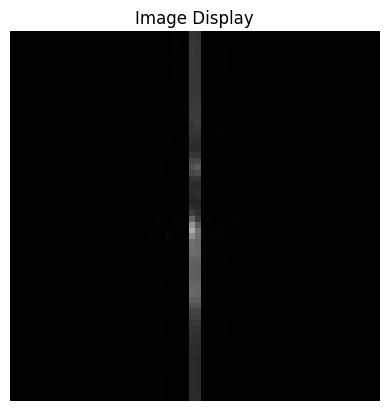

distance [43.39406967 12.13003063  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
box2D [0.99729827 1.         0.46827777 0.5648501 ]
box3D [21.31129716 -0.06919985 30.87723403  1.797       4.441       1.923
  0.95748938  1.53471257 -0.6511328 ]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

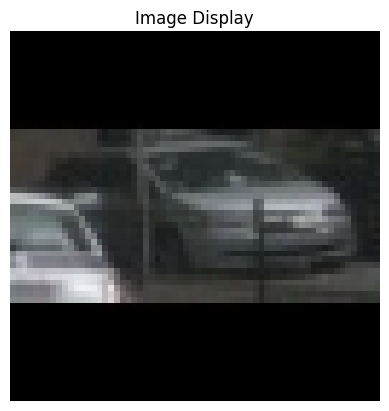

distance [21.7912674  16.25853729 21.66313744 22.59135818 14.24569321 22.18317223
 22.65211868 21.89250755 21.81550217 32.35105515 32.40015793 23.41085815
 23.32393646 32.39291    26.8143425  18.18855095 13.17700195 32.3523674
 17.77379608 32.36105347 32.29596329 18.88662338 21.92338181 16.15200043
 32.35985565 25.88981628 21.95099449 23.59718132 22.14274788 23.77050209
 21.19442368 18.94369125 23.49700546 22.35210609 32.35033417 13.09696388
 32.34840012 21.61060333 21.92139816 13.10484505 13.10782146 22.66024017
 22.4110527  13.51905346 13.08833981 32.36388016 22.69298935 13.09900951
 13.1331358  22.564991   13.09535694 22.53269577 14.03972816 17.92852974
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
box2D [0.84097831 0.98465342 0.48975059 0.61103908]
box3D [12.760523    0.52340438 25.66697887  1.995       4.969       1.958
  0.9679295   1.53260792 -0.6339966 ]
0.01568627450980392
0.0
0.0
0.01568627450980392
0.0
0.0


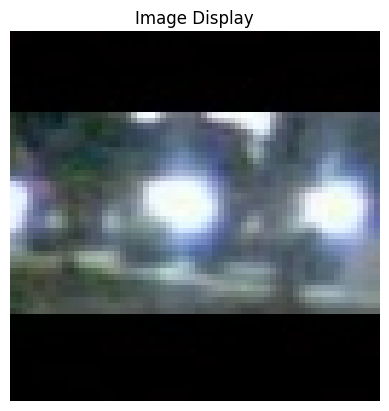

distance [39.61672974 48.61068726 91.40850067 34.66907883 49.42975616  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
box2D [0.71712831 0.76951566 0.52925127 0.58141372]
box3D [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize samples from the data generator
def visualize_samples(generator, num_samples=1):
    # Loop over a few samples from the generator
    for i in range(num_samples):
        # Get a batch of data
        batch_data = generator[i]
        images = batch_data[0]['image_input']
        distances = batch_data[0]['distances_input']
        boxes_2D = batch_data[0]['box_2D_input']
        boxes_3D = batch_data[1]
        # Loop over each image in the batch
        for j in range(3):
            image = images[j]
            distance = distances[j]
            box_2D = boxes_2D[j]
            box_3D = boxes_3D[j]
            flattened_image = np.array(image).flatten()

            # Iterate over the flattened image array (if needed)
            for i in range(len(flattened_image)):
                # Do something with each pixel value
                print(flattened_image[i])
            print('image', (image))
            plt.imshow(image, cmap='gray')
            plt.title('Image Display')
            plt.axis('off')  # Hide the axis
            plt.show()
            print('distance', distance)
            print('box2D', box_2D)
            print('box3D', box_3D)

visualize_samples(data_generator_train)

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, Model



def translation_error_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Ensure both y_true and y_pred are tensors of the same shape
    assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must be the same"


    #take the first three elemeents only
    y_true = y_true[:, :3]
    y_pred = y_pred[:, :3]
    # Calculate squared differences
    squared_diff = tf.square(y_true - y_pred)

    # Sum along the appropriate axis (typically axis=-1 for summing across dimensions)
    sum_squared_diff = tf.reduce_sum(squared_diff, axis=-1)

    # Take square root to get Euclidean distance
    euclidean_dist = tf.sqrt(sum_squared_diff)

    # Calculate mean over the batch
    mean_euclidean_dist = tf.reduce_mean(euclidean_dist)

    return mean_euclidean_dist

def maximize_3d_union_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Extract coordinates and dimensions from y_true and y_pred
    true_coords = y_true[:, :3]
    pred_coords = y_pred[:, :3]
    true_dims = y_true[:, 3:6]  # Assuming width, height, length
    pred_dims = y_pred[:, 3:6]  # Assuming width, height, length

    # Calculate corners of true and predicted bounding boxes
    true_corners = compute_corners(true_coords, true_dims)
    pred_corners = compute_corners(pred_coords, pred_dims)

    # Compute volumes of true and predicted boxes
    true_volume = tf.reduce_prod(true_dims, axis=-1)
    pred_volume = tf.reduce_prod(pred_dims, axis=-1)

    # Compute intersection volume
    intersection_volume = compute_intersection_volume(true_corners, pred_corners)

    # Calculate union volume
    union_volume = true_volume + pred_volume - intersection_volume

    # Maximize the union volume (negative because we want to maximize while minimizing loss)
    loss = -tf.reduce_mean(union_volume)

    return loss

def compute_corners(coords, dims):
    # Compute corners of 3D bounding boxes based on center coordinates and dimensions
    half_dims = dims / 2.0
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    xmin, ymin, zmin = x - half_dims[:, 0], y - half_dims[:, 1], z - half_dims[:, 2]
    xmax, ymax, zmax = x + half_dims[:, 0], y + half_dims[:, 1], z + half_dims[:, 2]
    corners = tf.stack([xmin, ymin, zmin, xmax, ymax, zmax], axis=-1)
    return corners

def compute_intersection_volume(corners1, corners2):
    # Compute the intersection volume between two sets of 3D bounding box corners
    xmin1, ymin1, zmin1, xmax1, ymax1, zmax1 = tf.split(corners1, 6, axis=-1)
    xmin2, ymin2, zmin2, xmax2, ymax2, zmax2 = tf.split(corners2, 6, axis=-1)

    inter_xmin = tf.maximum(xmin1, xmin2)
    inter_ymin = tf.maximum(ymin1, ymin2)
    inter_zmin = tf.maximum(zmin1, zmin2)
    inter_xmax = tf.minimum(xmax1, xmax2)
    inter_ymax = tf.minimum(ymax1, ymax2)
    inter_zmax = tf.minimum(zmax1, zmax2)

    inter_dims = tf.maximum(0.0, inter_xmax - inter_xmin) * \
                 tf.maximum(0.0, inter_ymax - inter_ymin) * \
                 tf.maximum(0.0, inter_zmax - inter_zmin)

    intersection_volume = tf.reduce_prod(inter_dims, axis=-1)
    return intersection_volume
"""
# Define your neural network architecture
def create_model():
    # Define input layers
    image_height = 32
    image_width = 32
    num_channels = 1
    num_distances = 256
    num_classes = 9

    image_input = layers.Input(shape=(image_height, image_width, num_channels), name='image_input')
    distances_input = layers.Input(shape=(num_distances,), name='distances_input')
    box_2D_input = layers.Input(shape=(4,), name='box_2D_input')  

    # Simplified CNN with reduced depth and fewer parameters
    cnn = layers.Conv2D(16, (3, 3), activation='relu')(image_input)
    cnn = layers.MaxPooling2D((2, 2))(cnn)
    cnn = layers.Conv2D(8, (5, 5), activation='linear')(cnn)
    cnn = layers.MaxPooling2D((5, 5))(cnn)
    # Flatten the output of the convolutional layers
    cnn_output_flattened = layers.Flatten()(cnn)
    # Concatenate image features, distances, and 2D bounding box coordinates
    concatenated_features = layers.Concatenate()([cnn_output_flattened, distances_input, box_2D_input])
    factor = 10
    # Fully connected layers with reduced neurons
    fc1 = layers.Dense(128 * factor, activation='relu')(concatenated_features)
    fc2 = layers.Dense(64 * factor, activation='relu')(fc1)
    fc3 = layers.Dense(32 * factor, activation='relu')(fc2)
    #fc4 = layers.Dense(32 * factor, activation='relu')(fc3)
    # Output layer
    output = layers.Dense(num_classes, activation='leaky_relu')(fc3) #softplus, leaky_relu
    # Define model
    model = Model(inputs=[image_input, distances_input, box_2D_input], outputs=output)
    return model
"""
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, Model

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def swish(x):
    return x * tf.nn.sigmoid(x)
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_model():
    # Define input layers
    image_height = 64
    image_width = 64
    num_channels = 3
    num_distances = 64
    num_classes = 9
    activation = 'relu'
    activation2 = 'relu'

    image_input = layers.Input(shape=(image_height, image_width, num_channels), name='image_input')
    distances_input = layers.Input(shape=(num_distances,), name='distances_input')
    box_2D_input = layers.Input(shape=(4,), name='box_2D_input') 

    # New CNN structure
    cnn = layers.SeparableConv2D(8, (32, 32), strides=(2, 2), padding='same')(image_input)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Activation(activation)(cnn)
    cnn = layers.Conv2D(64, (9, 9), strides=(1, 1), padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Activation(activation)(cnn)
    cnn = layers.SeparableConv2D(16, (3, 3), strides=(2, 2), padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Activation(activation)(cnn)
    cnn = layers.Conv2D(16, (2, 2), strides=(1, 1), padding='same')(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Activation(activation)(cnn)
    cnn = layers.Flatten()(cnn)

    # Concatenate image features, distances, and 2D bounding box coordinates
    concatenated_features = layers.Concatenate()([box_2D_input, distances_input])

    # Fully connected layers
    fc1 = layers.Dense(64, kernel_regularizer=l2(0.01))(concatenated_features)
    fc1 = layers.BatchNormalization()(fc1)
    fc1 = layers.Activation(activation2)(fc1)
    fc1 = layers.Dropout(0.1)(fc1)

    fc1 = layers.Dense(64, kernel_regularizer=l2(0.01))(fc1)
    fc1 = layers.BatchNormalization()(fc1)
    fc1 = layers.Activation(activation2)(fc1)
    fc1 = layers.Dropout(0.1)(fc1)

    fc2 = layers.Dense(64, kernel_regularizer=l2(0.01))(fc1)
    fc2 = layers.BatchNormalization()(fc2)
    fc2 = layers.Activation(activation2)(fc2)
    fc2 = layers.Dropout(0.1)(fc2)

    """fc3 = layers.Dense(256, kernel_regularizer=l2(0.01))(fc2)
    fc3 = layers.BatchNormalization()(fc3)
    fc3 = layers.Activation(activation2)(fc3)
    fc3 = layers.Dropout(0.1)(fc3)

    fc4 = layers.Dense(128, kernel_regularizer=l2(0.01))(fc3)
    fc4 = layers.BatchNormalization()(fc4)
    fc4 = layers.Activation(activation2)(fc4)
    fc4 = layers.Dropout(0.1)(fc4)

    fc5 = layers.Dense(64, kernel_regularizer=l2(0.01))(fc4)
    fc5 = layers.BatchNormalization()(fc5)
    fc5 = layers.Activation(activation2)(fc5)"""

    # Output layer
    output = layers.Dense(num_classes, activation=activation2)(fc2)

    # Define model
    model = Model(inputs=[box_2D_input, distances_input], outputs=output)

    # Compile model
    #model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    # Compile the model with the custom loss function
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae', maximize_3d_union_loss, translation_error_loss])

    return model


# Create and compile the model
model = create_model()

# Display the model summary
model.summary()
# Compile your model, specifying the optimizer
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

checkpoint_filepath = 'home/uva_ki_nunoscholten/checkpointcar_norm4/model_car_epoch_{epoch:02d}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='home/uva_ki_nunoscholten/modelscar_norm4',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None)
# Define number of epochs
num_epochs = 1000

# Train the model with callbacks
#with tf.device('/gpu:2'):
history = model.fit(
    data_generator_train,
    validation_data=data_generator_val,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback, tensorboard_callback])






Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ box_2D_input        │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distances_input     │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 68)        │          0 │ box_2D_input[0][… │
│ (Concatenate)       │                   │            │ distances_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │      4,416 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ activation_56[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      4,160 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64)        │          0 │ activation_57[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      4,160 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ activation_58[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 9)         │        585 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,089 (55.04 KB)

 Trainable params: 13,705 (53.54 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/1000


2024-06-27 09:42:09.899515: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-06-27 09:42:09.899555: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-06-27 09:42:09.899618: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


1/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 45.1232 - mae: 2.6587 - maximize_3d_union_loss: -8.0018 - translation_error_loss: 13.1497

2024-06-27 09:42:12.235310: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-06-27 09:42:12.235335: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


2/7 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 45.1510 - mae: 2.6590 - maximize_3d_union_loss: -8.0041 - translation_error_loss: 13.1509

2024-06-27 09:42:12.511022: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-06-27 09:42:12.514899: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-06-27 09:42:12.516810: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: home/uva_ki_nunoscholten/modelscar_norm4/plugins/profile/2024_06_27_09_42_12/nuno120-G14.xplane.pb


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 45.1533 - mae: 2.6561 - maximize_3d_union_loss: -8.0078 - translation_error_loss: 13.1361 - val_loss: 41.6376 - val_mae: 2.7360 - val_maximize_3d_union_loss: -8.3343 - val_translation_error_loss: 13.1178
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 44.4932 - mae: 2.7594 - maximize_3d_union_loss: -8.3625 - translation_error_loss: 13.3557 - val_loss: 43.0569 - val_mae: 2.7434 - val_maximize_3d_union_loss: -8.3650 - val_translation_error_loss: 13.4953
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 41.7779 - mae: 2.6899 - maximize_3d_union_loss: -7.9348 - translation_error_loss: 12.9682 - val_loss: 39.9012 - val_mae: 2.6103 - val_maximize_3d_union_loss: -8.0959 - val_translation_error_loss: 12.6860
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 41.8966 - mae: 2.6610 - maximize_3d_union_loss: -8.1075 - translation_error_loss: 12.8685 - val_loss: 38.7852 - val_mae: 2.4845 - val_maximize_3d_union_loss: -7.779

In [37]:
model.save('/home/nuno120/Documents/SCRIPTIE/home/car_3Dmodel_smalldataset_2dboxlidar_transerror7_6602.h5') 

In [28]:
model = tf.keras.models.load_model('/home/nuno120/Documents/SCRIPTIE/home/car_3Dmodel_smalldataset_camlidardirect_transerror6.9041.h5', custom_objects={'mse': 'mse', 'mae': 'mae', 'maximize_3d_union_loss': maximize_3d_union_loss, 'translation_error_loss': translation_error_loss})

In [38]:
num_batches = 100

import time
# Measure the inference time over multiple batches
total_time = 0
for i, batch in enumerate(data_generator_val):
    if i >= num_batches:
        break
    start_time = time.time()
    _ = model.predict(batch[0])  # batch[0] contains the input data
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_batches
print(f'Average inference time over {num_batches} batches: {average_inference_time:.6f} seconds')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7

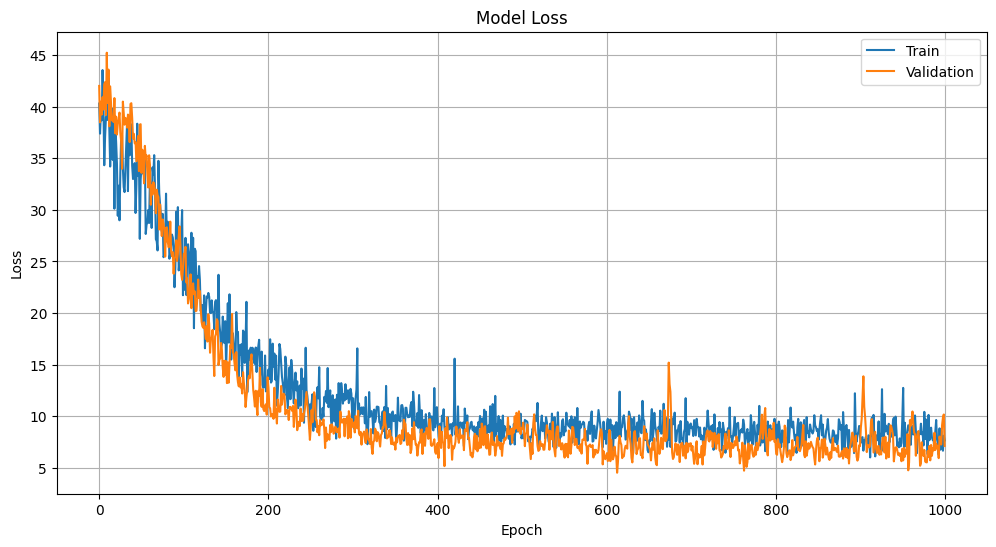

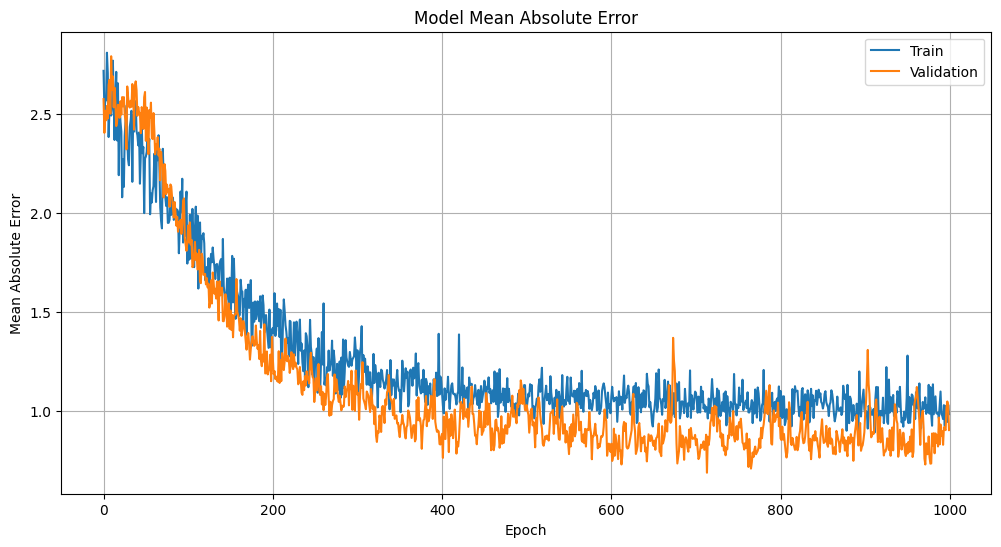

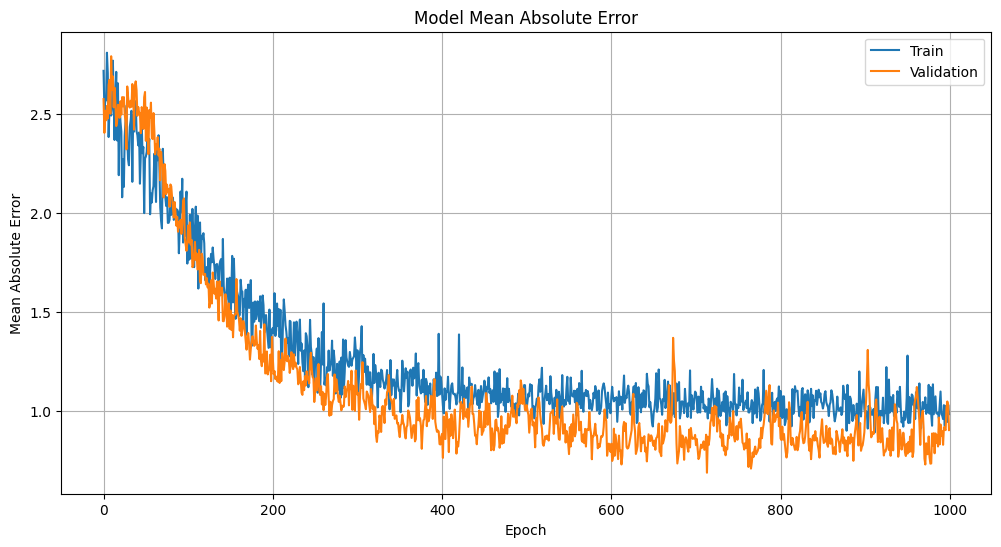

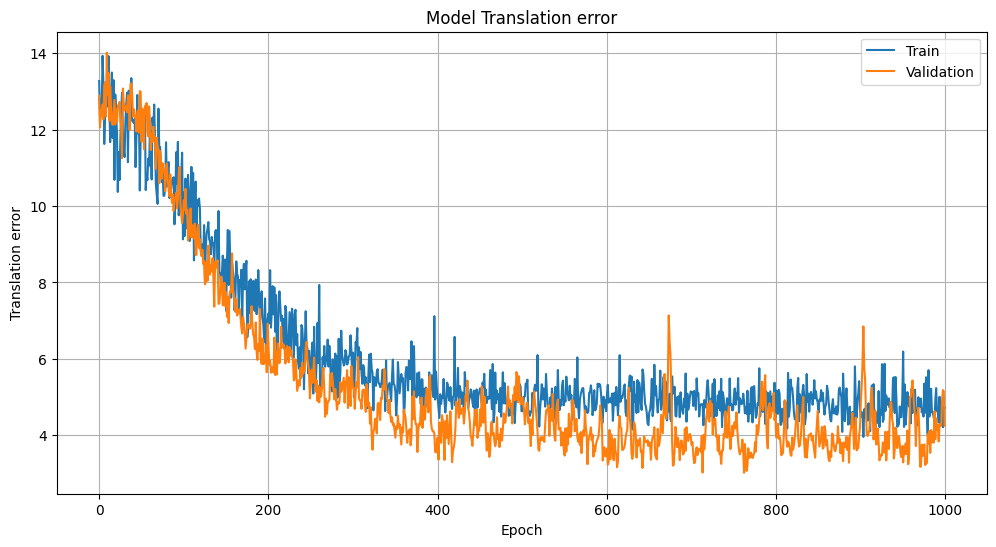

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

# If you have other metrics like 'mae' (Mean Absolute Error), you can plot them similarly
if 'mae' in history.history and 'val_mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)
    plt.show()


# If you have other metrics like 'mae' (Mean Absolute Error), you can plot them similarly
if 'mae' in history.history and 'val_mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)
    plt.show()

# If you have other metrics like 'mae' (Mean Absolute Error), you can plot them similarly
if 'translation_error_loss' in history.history and 'val_translation_error_loss' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['translation_error_loss'])
    plt.plot(history.history['val_translation_error_loss'])
    plt.title('Model Translation error')
    plt.xlabel('Epoch')
    plt.ylabel('Translation error')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)
    plt.show()

Error importing module 'NuScenesExplorer' from 'nuscenes-devkit/python-sdk/nuscenes/nuscenes.py': [Errno 2] No such file or directory: '/home/nuno120/Documents/SCRIPTIE/nuscenes-devkit/python-sdk/nuscenes/nuscenes.py'


Traceback (most recent call last):
  File "/tmp/ipykernel_5759/2326155462.py", line 78, in <module>
    spec.loader.exec_module(NuScExpl)
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1016, in get_code
  File "<frozen importlib._bootstrap_external>", line 1073, in get_data
FileNotFoundError: [Errno 2] No such file or directory: '/home/nuno120/Documents/SCRIPTIE/nuscenes-devkit/python-sdk/nuscenes/nuscenes.py'


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.435 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
cropped_image_sample_342_camera_CAM_FRONT_0.jpg
threeD box real: label: nan, score: nan, xyz: [8.88, 0.51, 16.93], wlh: [1.86, 5.00, 1.76], rot axis: [0.60, 0.57, -0.56], ang(degrees): 117.65, ang(rad): 2.05, vel: nan, nan, nan, name: None, token: None


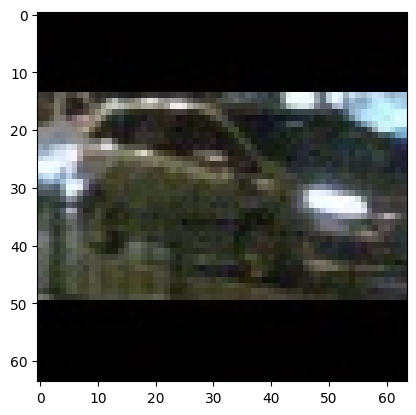

twoD box: [[0.82803514 1.         0.51003998 0.68351859]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
predicted box: label: nan, score: nan, xyz: [-21.29, -1.32, 0.30], wlh: [0.07, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.63, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
Translation error: 34.4907807401811
cropped_image_sample_342_camera_CAM_FRONT_1.jpg
threeD box real: label: nan, score: nan, xyz: [12.71, 0.67, 19.95], wlh: [1.89, 4.67, 1.59], rot axis: [-0.52, -0.61, 0.60], ang(degrees): -124.62, ang(rad): -2.17, vel: nan, nan, nan, name: None, token: None


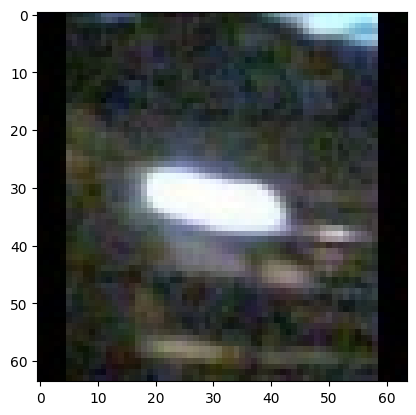

twoD box: [[0.93762969 1.         0.53575542 0.66517854]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted box: label: nan, score: nan, xyz: [-21.28, -1.32, 0.34], wlh: [0.06, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.68, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
Translation error: 39.283211058858015
cropped_image_sample_342_camera_CAM_FRONT_2.jpg
threeD box real: label: nan, score: nan, xyz: [11.49, 0.04, 26.80], wlh: [2.10, 5.37, 2.46], rot axis: [0.59, 0.57, -0.56], ang(degrees): 118.21, ang(rad): 2.06, vel: nan, nan, nan, name: None, token: None


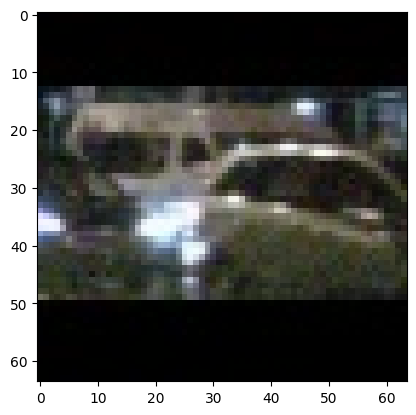

twoD box: [[0.78701039 0.92529547 0.47690754 0.62182293]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted box: label: nan, score: nan, xyz: [-21.29, -1.32, 0.30], wlh: [0.07, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.63, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
Translation error: 42.17121764850555
cropped_image_sample_342_camera_CAM_FRONT_3.jpg
threeD box real: label: nan, score: nan, xyz: [-0.07, 0.31, 18.15], wlh: [1.82, 4.29, 1.85], rot axis: [-0.57, 0.58, -0.59], ang(degrees): -121.92, ang(rad): -2.13, vel: nan, nan, nan, name: None, token: None


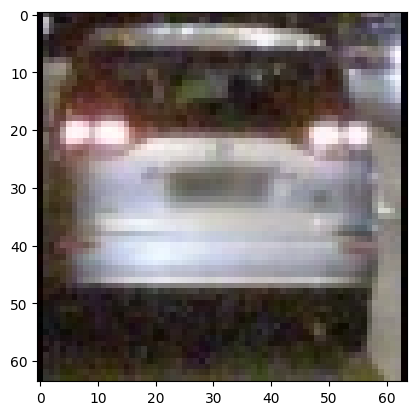

twoD box: [[0.46531773 0.55654038 0.49180824 0.65636975]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted box: label: nan, score: nan, xyz: [-21.27, -1.32, 0.33], wlh: [0.07, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.67, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
Translation error: 27.745908522965266
cropped_image_sample_342_camera_CAM_FRONT_4.jpg
threeD box real: label: nan, score: nan, xyz: [8.61, 0.34, 25.00], wlh: [1.69, 4.35, 1.76], rot axis: [0.60, 0.57, -0.56], ang(degrees): 117.65, ang(rad): 2.05, vel: nan, nan, nan, name: None, token: None


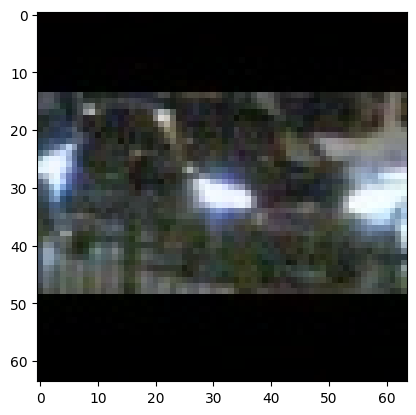

twoD box: [[0.73253734 0.84241448 0.51307496 0.6226233 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted box: label: nan, score: nan, xyz: [-21.28, -1.32, 0.32], wlh: [0.07, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.65, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
Translation error: 38.80275648924849
cropped_image_sample_342_camera_CAM_FRONT_7.jpg
threeD box real: label: nan, score: nan, xyz: [-6.90, -0.60, 39.75], wlh: [0.64, 0.55, 1.77], rot axis: [0.60, 0.57, -0.56], ang(degrees): 117.64, ang(rad): 2.05, vel: nan, nan, nan, name: None, token: None


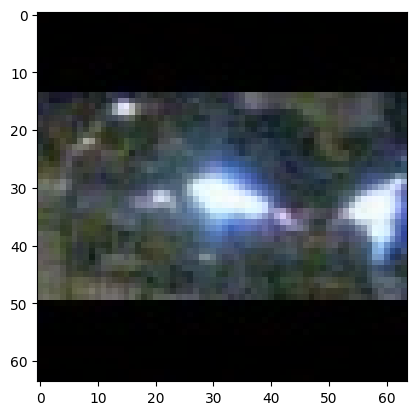

twoD box: [[0.36549262 0.38005223 0.49315672 0.556668  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted box: label: nan, score: nan, xyz: [-21.28, -1.32, 0.34], wlh: [0.06, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.68, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
Translation error: 41.96405587277657
label: nan, score: nan, xyz: [-21.29, -1.32, 0.30], wlh: [0.07, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.63, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
center visualizing box: [-3.0172223654690455, 0.5675938446431552, 32.31389596114775]
label: nan, score: nan, xyz: [-21.28, -1.32, 0.34], wlh: [0.06, -0.33, 0.14], rot axis: [-0.61, 0.49, -0.63], ang(degrees): -130.68, ang(rad): -2.28, vel: nan, nan, nan, name: None, token: None
center visualizing box: [-3.0172223654690455, 0.5675938446431552, 32.31389596114775]
label: nan, score: nan, xyz: [-21.29, -1.32, 0.30], wlh: [0.07, -0.33, 0.14], rot axis: [-0.61, 0.49

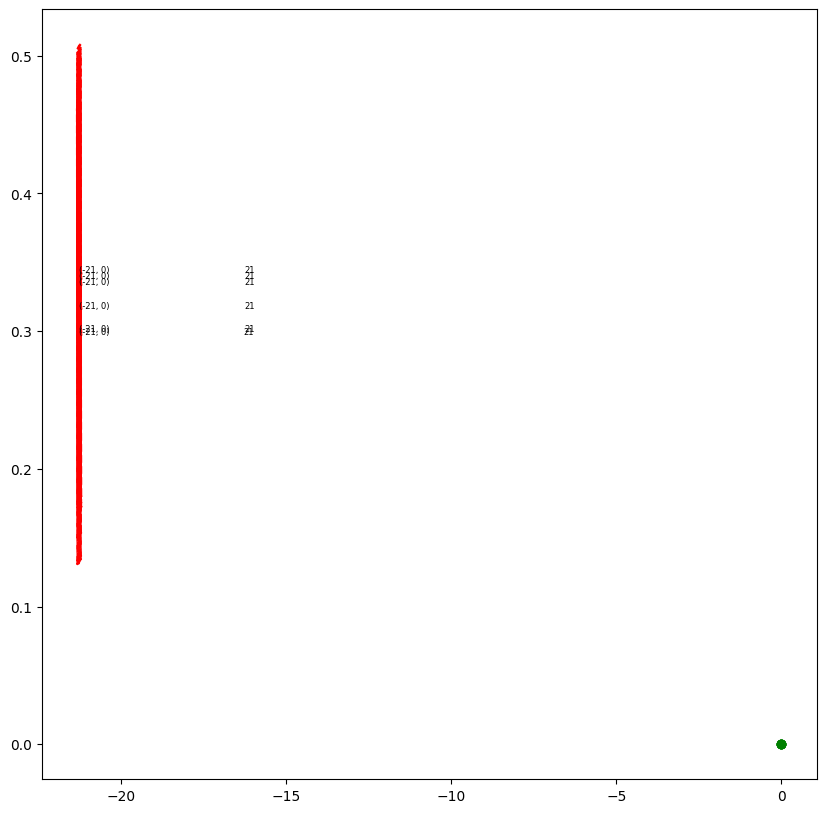

big_image: /home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT/n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542800856912460.jpg


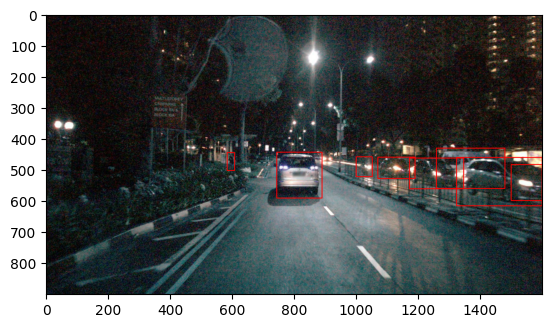

boxes from nuscenes
label: nan, score: nan, xyz: [11.49, 0.04, 26.80], wlh: [2.10, 5.37, 2.46], rot axis: [-0.59, -0.57, 0.56], ang(degrees): -118.21, ang(rad): -2.06, vel: nan, nan, nan, name: vehicle.car, token: 54b0482414214fdd8ce72bf23032e781
center visualizing box: [-3.0172223654690455, 0.5675938446431552, 32.31389596114775]
label: nan, score: nan, xyz: [-0.07, 0.31, 18.15], wlh: [1.82, 4.29, 1.85], rot axis: [-0.57, 0.58, -0.59], ang(degrees): -121.92, ang(rad): -2.13, vel: nan, nan, nan, name: vehicle.car, token: cbaf6e83c3aa4e47aaab8f8652fc1112
center visualizing box: [-3.0172223654690455, 0.5675938446431552, 32.31389596114775]
label: nan, score: nan, xyz: [8.61, 0.34, 25.00], wlh: [1.69, 4.35, 1.76], rot axis: [-0.60, -0.57, 0.56], ang(degrees): -117.65, ang(rad): -2.05, vel: nan, nan, nan, name: vehicle.car, token: 3e4a2e04ee0b4a91852c7dd60de9d431
center visualizing box: [-3.0172223654690455, 0.5675938446431552, 32.31389596114775]
label: nan, score: nan, xyz: [-6.90, -0.60, 3

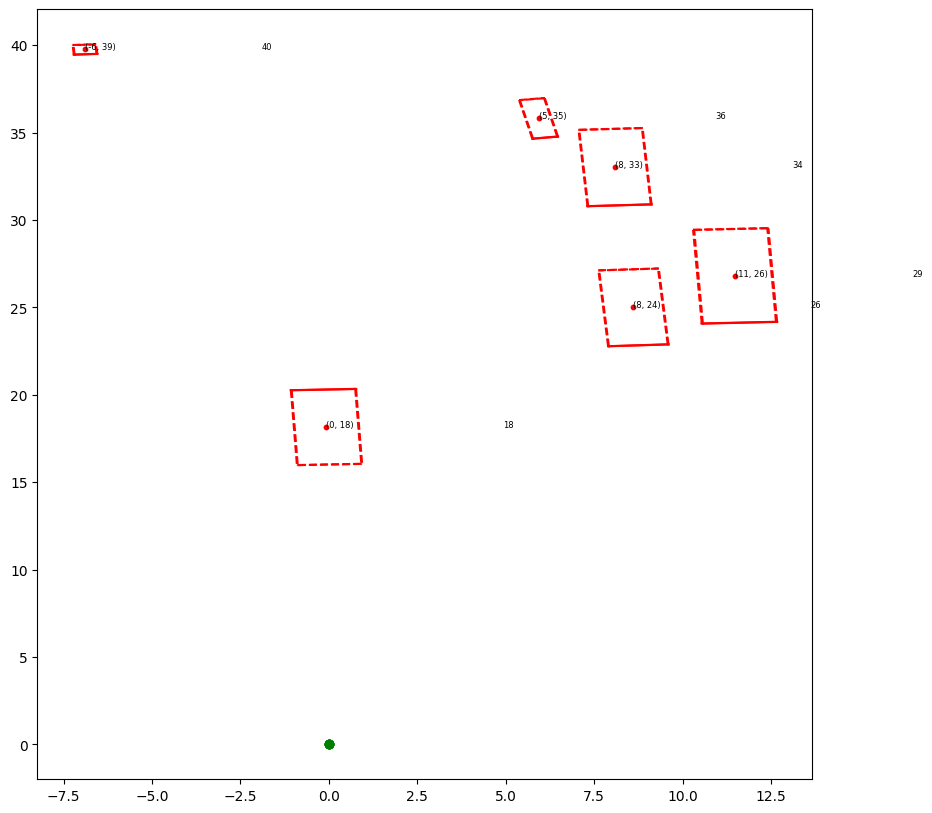

mkdir: cannot create directory ‘/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results’: File exists


detect_dual: weights=['/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt'], source=/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes/samples/CAM_FRONT/n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542800856912460.jpg, data=yolov9/data/coco128.yaml, imgsz=[1216, 1216], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/nuno120/Documents/SCRIPTIE/yolov9/results, name=latest_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 2024-4-20 Python-3.10.0 torch-2.3.0+cu121 CPU

Fusing layers... 
yolov9-c summary: 604 layers, 50719068 parameters, 0 gradients, 236.7 GFLOPs
Traceback (most recent call last):
  File "/home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py", line 233, in <module>
    main(opt)
  File "/home/nuno120/Documents

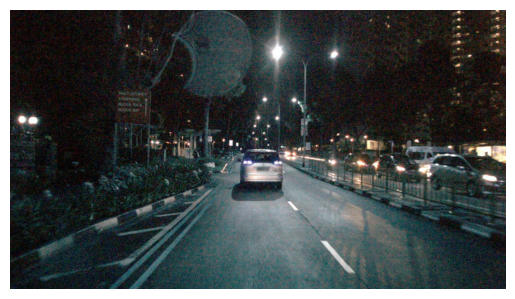

UnboundLocalError: local variable 'min_x' referenced before assignment

<Figure size 640x480 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility
from pyquaternion import Quaternion
import numpy as np
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import importlib.util
import sys
import glob
import os
import importlib.util
import sys
import traceback
import tensorflow as tf
def run_yolo(image_path, imsz=1216, conf_threshold=0.7, weights_path="/home/nuno120/Downloads/results_DownlOAD/hva_exp13_imgs1200/epoch78.pt", visualize=False):
    image = cv2.imread(image_path)
    device = "cpu"
    latest_results = "/home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results"
    #make the directory
    os.system('mkdir /home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results')
    #empty the folder
    os.system('rm -rf /home/nuno120/Documents/SCRIPTIE/yolov9/results/latest_results')
    # Run YOLOv5 on the image
    image_width, image_height = image.shape[1], image.shape[0]
    !python /home/nuno120/Documents/SCRIPTIE/yolov9/detect_dual.py --weights {weights_path} --imgsz {imsz} --conf {conf_threshold} --source {image_path} --save-txt --save-conf --save-crop --project /home/nuno120/Documents/SCRIPTIE/yolov9/results --name latest_results --exist-ok 
    #open the latest_results/labels folder and find the file with the camera name in it
    classes, confidences, x_min, x_max, y_min, y_max= [],[],[],[],[],[]
    for filename in os.listdir(latest_results+'/labels'):
        with open(latest_results+'/labels/'+filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                #split on spaces
                line = line.split()
                category, x, y, w, h,conf = int(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4]), float(line[5])
                #if category == 3:
                classes.append(category)
                confidences.append(conf)
                #now convert the boxes to xmin,ymin, xmax, ymax
                min_x, min_y, max_x, max_y = convert_from_yolo_format([x,y,w, h], image_width, image_height)
                #append
                x_min.append(min_x)
                y_min.append(min_y)
                x_max.append(max_x)
                y_max.append(max_y)

    if visualize:
        plt.clf()
        plt.imshow(image)
        for i in range(len(x_min)):
            plt.plot([x_min[i], x_max[i], x_max[i], x_min[i], x_min[i]], [y_min[i], y_min[i], y_max[i], y_max[i], y_min[i]], 'r-')
            #show the classes nnumber
            plt.text(x_min[i], y_min[i], classes[i], color='red', fontsize=8)
        plt.axis('off')
        plt.show()
        plt.clf()

    return min_x, min_y, max_x, max_y, conf, classes


# Define the module name and file path
module_name = 'NuScenesExplorer'
file_path = 'nuscenes-devkit/python-sdk/nuscenes/nuscenes.py'

try:
    # Load the module specification from the file location
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Cannot find module '{module_name}' at '{file_path}'")

    # Create a new module based on the specification
    NuScExpl = importlib.util.module_from_spec(spec)

    # Execute the module in its own namespace
    spec.loader.exec_module(NuScExpl)

    # Optionally, add the module to sys.modules
    sys.modules[module_name] = NuScExpl

    # <Now you can use the imported module
    print(f"Module '{module_name}' loaded successfully from '{file_path}'")
except Exception as e:
    print(f"Error importing module '{module_name}' from '{file_path}': {e}")
    traceback.print_exc()


def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ALL, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #%matplotlib widget
    #ax =  plt.figure().add_subplot(111, projection='3d')
    #for box in box_list:
        #print('center: ', box.center)
        #print(box)
        #box.render(axis =ax)
    #ax.scatter(0, 0, 0, c='g', marker='o')
    
    
    return data_path, box_list, ann_list, cam_intrinsic #single image info


# Function to convert YOLO format to bounding box coordinates
def convert_from_yolo_format(yolo_box, image_width, image_height):
    x_center = yolo_box[0]
    y_center = yolo_box[1]
    normalized_width = yolo_box[2]
    normalized_height = yolo_box[3]
    
    width = normalized_width * image_width
    height = normalized_height * image_height
    
    x_min = (x_center - normalized_width / 2) * image_width
    y_min = (y_center - normalized_height / 2) * image_height
    
    x_max = x_min + width
    y_max = y_min + height
    
    return round(x_min), round(y_min), round(x_max), round(y_max)
def visualize_boxes_top_view(ax, box, color='r'):
    '''
    input 3D box
    output ax with 3D box plotted in 2D (top view)
    '''
    print(box)
    x,y,z = box.center
    print('center visualizing box:', center)
    #plot the x and y 
    ax.scatter(x, z, c=color, marker='o', label= f"{x,z}", s=10)
    #add text with the center of the box
    distance = np.sqrt(x**2 + y**2 + z**2)
    ax.text(x+5, z, f"{int(distance)}", fontsize=6)
    ax.text(x, z, f"{int(x),int(z)}", fontsize=6)



    # Get the corners of the 3D box
    corners = box.corners()
    
    # Extract x, y coordinates for top view (ignore z)
    x = corners[0, :]
    y = corners[2, :]
    
    # Plot the top view of the box
    ax.plot([x[0], x[1]], [y[0], y[1]], f'{color}-') # Front side
    ax.plot([x[1], x[2]], [y[1], y[2]],  f'{color}-') # Right side
    ax.plot([x[2], x[3]], [y[2], y[3]],  f'{color}-') # Back side
    ax.plot([x[3], x[0]], [y[3], y[0]],  f'{color}-') # Left side
    ax.plot([x[4], x[5]], [y[4], y[5]],  f'{color}--') # Top front side
    ax.plot([x[5], x[6]], [y[5], y[6]],  f'{color}--') # Top right side
    ax.plot([x[6], x[7]], [y[6], y[7]],  f'{color}--') # Top back side
    ax.plot([x[7], x[4]], [y[7], y[4]],  f'{color}--') # Top left side
    ax.plot([x[0], x[4]], [y[0], y[4]],  f'{color}--') # Connection 1
    ax.plot([x[1], x[5]], [y[1], y[5]],  f'{color}--') # Connection 2
    ax.plot([x[2], x[6]], [y[2], y[6]],  f'{color}--') # Connection 3
    ax.plot([x[3], x[7]], [y[3], y[7]],  f'{color}--') # Connection 4

    #add 0,0,0
    ax.scatter(0, 0, c='g', marker='o')
    return ax


from tensorflow.keras import backend as K

def smooth_l1_loss(y_true, y_pred, delta=1.0):
    diff = K.abs(y_true - y_pred)
    less_than_delta = K.cast(K.less(diff, delta), "float32")
    loss = less_than_delta * 0.5 * diff**2 + (1 - less_than_delta) * (diff - 0.5 * delta)
    return loss

def custom_loss(y_true, y_pred):
    # Split the predicted and true values into center, size, and orientation components
    y_true_center, y_true_size, y_true_orientation = y_true[:, :3], y_true[:, 3:6], y_true[:, 6:]
    y_pred_center, y_pred_size, y_pred_orientation = y_pred[:, :3], y_pred[:, 3:6], y_pred[:, 6:]

    # Compute the Euclidean distance for the center
    center_distance = K.sqrt(K.sum(K.square(y_true_center - y_pred_center), axis=-1))
    
    # Define a high penalty if the distance is greater than 0.5 meters
    center_threshold = 0.5
    center_loss = tf.where(center_distance > center_threshold,
                           smooth_l1_loss(center_distance, center_threshold) * 1000,  # High penalty
                           smooth_l1_loss(center_distance, 0))  # Regular penalty

    # Compute the Smooth L1 Loss for size and orientation
    size_loss = K.mean(smooth_l1_loss(y_true_size, y_pred_size), axis=-1)
    orientation_loss = K.mean(smooth_l1_loss(y_true_orientation, y_pred_orientation), axis=-1)

    # Combine the losses, giving more weight to the size and orientation
    total_loss = K.mean(center_loss + size_loss + orientation_loss)

    return total_loss


def load_custom_model(model_path):
    def translation_error_loss(y_true, y_pred):
        # Ensure both y_true and y_pred are of the same type (float32)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Extract the translation components (x, y, z)
        y_true_translation = y_true[:, :3]
        y_pred_translation = y_pred[:, :3]
        
        # Calculate the Mean Squared Error (MSE) for the translation components
        translation_error = tf.reduce_mean(abs(y_true_translation - y_pred_translation))
        
        return translation_error

    model = tf.keras.models.load_model(model_path, custom_objects={'translation_error_loss': translation_error_loss})
    return model

# Load the model
#model = load_custom_model('/home/nuno120/Documents/SCRIPTIE/model_car_epoch_39.keras')
model = load_custom_model('home/uva_ki_nunoscholten/checkpointcar_norm4/model_car_epoch_49.keras')


samplenumber_in_list = 10
#now get the metadata file
metadata_file = filtered_sample_list[samplenumber_in_list]['metadata_file']
samplenumber, camera_name, _ = extract_info_from_filename(metadata_file)

#open the metadata file
metadata_file = os.path.join(path, metadata_file)
#print(metadata_file)
#now get the names
threeD_boxes, twoD_boxes, indexxes, names = read_metadata_and_get_data(metadata_file)


images = [0 for x in range(len(indexxes))]
distances = [0 for x in range(len(indexxes))]
#now get the image file
for i in range(len(filtered_sample_list)):
    for index in indexxes:
        if filtered_sample_list[i]['index'] == index:
            if filtered_sample_list[i]['sample_number'] == samplenumber:
                image_file = filtered_sample_list[i]['image_file']
                distance_file = filtered_sample_list[i]['distance_file']
                _, camera_name_found, _ = extract_info_from_filename(image_file)

                if camera_name == camera_name_found:
                    #set them at the index in images and distances list
                    images[index] = image_file

                _, camera_name_found, _ = extract_info_from_filename(distance_file)
                if camera_name == camera_name_found:
                    distances[index] = distance_file

#remove the 0's
images = [x for x in images if x != 0]
distances = [x for x in distances if x != 0]
#now find the image for the sample number
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/home/nuno120/Documents/SCRIPTIE/data/sets/nuscenes', verbose=True)
#print('images', images)
#print('distances', distances)
#now show the images. the names, twod boxes, threed boxes 
predicted_boxes = []
for i in range(len(images)):
    print(images[i])
    image_cropped = cv2.imread(os.path.join(path, images[i]))
    image_cropped = image_cropped/255

    
    distance = np.load(os.path.join(path, distances[i]))
    


    name = names[i]
    twoD_box = twoD_boxes[i]
    #convert
    threeD_box = threeD_boxes[i]
    center_real = threeD_box[0:3]
    
    size = threeD_box[3:6]
    euler = threeD_box[6:9]

    x,y,z,w = get_quaternion_from_euler(euler[0], euler[1], euler[2])
    orientation = Quaternion(w,x,y,z)
    threeD_box = Box(center_real, size, orientation)
    #visualize_boxes_top_view(ax_2d, threeD_box, color = 'b')
    print('threeD box real:', threeD_box)
    #normalize the image
    #image = image / 255
    plt.imshow(image_cropped)
    plt.show()
    #expand the dimensions
    #predict the boxes
    distance = normalize(distance, loaded_normalization_stats[0], loaded_normalization_stats[1])
    #print('Distance:', distance)
    image_cropped = np.expand_dims(image_cropped, axis=0)
    distance = np.expand_dims(distance, axis=0)
    twoD_box = np.expand_dims(twoD_box, axis=0)
    print('twoD box:', twoD_box)
    threeD_box = np.expand_dims(threeD_box, axis=0)

    
    #print('dist len', distance)
    #print('twoD box lem', twoD_box)
    shape = 64,64
    image_cropped = tf.image.resize(image_cropped, shape)
    prediction = model.predict([image_cropped, distance, twoD_box])
    
    #print('Prediction:', prediction)
    #now we need to denormalize the prediction

    x,y,z,w,l,h,roll,pitch,yaw = prediction[0]


    #now denoralize using the normalization stats using min max scaling
    min_x = loaded_normalization_stats[2]
    max_x = loaded_normalization_stats[3]
    x = x * (max_x - min_x) + min_x
    y = y * (loaded_normalization_stats[5] - loaded_normalization_stats[4]) + loaded_normalization_stats[4]
    z = z * (loaded_normalization_stats[7] - loaded_normalization_stats[6]) + loaded_normalization_stats[6]
    w = w * (loaded_normalization_stats[9] - loaded_normalization_stats[8]) + loaded_normalization_stats[8]
    l = l * (loaded_normalization_stats[11] - loaded_normalization_stats[10]) + loaded_normalization_stats[10]
    h = h * (loaded_normalization_stats[13] - loaded_normalization_stats[12]) + loaded_normalization_stats[12]
    roll = roll * (loaded_normalization_stats[15] - loaded_normalization_stats[14]) + loaded_normalization_stats[14]
    pitch = pitch * (loaded_normalization_stats[17] - loaded_normalization_stats[16]) + loaded_normalization_stats[16]
    yaw = yaw * (loaded_normalization_stats[19] - loaded_normalization_stats[18]) + loaded_normalization_stats[18]

    """x = x * loaded_normalization_stats[3] + loaded_normalization_stats[2]
    y = y * loaded_normalization_stats[5] + loaded_normalization_stats[4]
    z = z * loaded_normalization_stats[7] + loaded_normalization_stats[6]
    w = w * loaded_normalization_stats[9] + loaded_normalization_stats[8]
    l = l * loaded_normalization_stats[11] + loaded_normalization_stats[10]
    h = h * loaded_normalization_stats[13] + loaded_normalization_stats[12]
    roll = roll * loaded_normalization_stats[15] + loaded_normalization_stats[14]
    pitch = pitch * loaded_normalization_stats[17] + loaded_normalization_stats[16]
    yaw = yaw * loaded_normalization_stats[19] + loaded_normalization_stats[18]"""
    prediction = [x,y,z,w,l,h,roll,pitch,yaw]

    center_prediction = prediction[0:3]
    size = prediction[3:6]
    euler = prediction[6:9]

    x,y,z,w = get_quaternion_from_euler(euler[0], euler[1], euler[2])
    orientation = Quaternion(w,x,y,z)
    threeD_box = Box(center_prediction, size, orientation)
    predicted_boxes.append(threeD_box)
    print('predicted box:', threeD_box)
    #print('Prediction:', prediction)

    #now also plot the prediction
    translation_error = np.sqrt((center_prediction[0] - center_real[0])**2 + (center_prediction[1] - center_real[1])**2 + (center_prediction[2] - center_real[2])**2)
    print('Translation error:', translation_error)
    #print('Name:', name)
    
    #print('TwoD:', twoD_box)
    #print('ThreeD:', threeD_box)
    #print('-------------------------------------')
    #plt.imshow(image)
    #plt.show()

fig, ax_2d = plt.subplots(figsize=(10, 10))
for i in range(len(predicted_boxes)):
    visualize_boxes_top_view(ax_2d, predicted_boxes[i], color = 'r')
plt.show()
plt.clf()

plt.clf()
#now get the sample data token
sample_token = nusc.sample[samplenumber]['data'][camera_name]
data_path, box_list, ann_list, cam_intrinsic = get_sample_data(nusc, sample_token)

image = cv2.imread(data_path)
print('big_image:', data_path)
for i in range(len(twoD_boxes)):
    twoD_box = twoD_boxes[i]
    #print(twoD_box)
    xmin, xmax, ymin,ymax = twoD_box
    xmin, xmax, ymin,ymax = int(xmin * 1600), int(xmax * 1600), int(ymin * 900), int(ymax*900)
    #print(xmin, xmax,ymin,ymax)
    
    image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), color=(255,0,0), thickness=2)

plt.imshow(image)
plt.show()

#now plot the boxes
print('boxes from nuscenes')
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(box_list)):
    box = box_list[i]
    visualize_boxes_top_view(ax, box)
plt.show()
plt.clf()

image = cv2.imread(data_path)
run_yolo(data_path, conf_threshold=0.5, visualize=True)

"""x_min, x_max, y_min, y_max = x_min * 1600, x_max * 1600, y_min * 900, y_max * 900
    #if they are negative, make them 0
    x_min = 0 if x_min < 0 else x_min
    x_max = 0 if x_max < 0 else x_max
    y_min = 0 if y_min < 0 else y_min
    y_max = 0 if y_max < 0 else y_max

    #if they are bigger than the image size, make them the image size
    x_min = 1600 if x_min > 1600 else x_min
    x_max = 1600 if x_max > 1600 else x_max
    y_min = 900 if y_min > 900 else y_min
    y_max = 900 if y_max > 900 else y_max

    print(x_min, x_max, y_min, y_max)
    #plot on image the box
    #cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
    plt.imshow(cropped_image)
    plt.show()
    #now make the image 32x32 by squishing/stretching the short/long side to 32 and then padding the other side with 0's
    #first check if the image is landscape or portrait
    if cropped_image.shape[0] > cropped_image.shape[1]:
        #portrait
        new_height = 32
        new_width = int(cropped_image.shape[1] * (new_height / cropped_image.shape[0]))
        cropped_image = cv2.resize(cropped_image, (new_width, new_height), interpolation = cv2.INTER_AREA)
        #now pad the height with 0's
        #now pad the width with 0's
        pad = 32 - new_width
        left = pad // 2
        right = pad - left
        cropped_image = cv2.copyMakeBorder(cropped_image, 0, 0, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    else:
        #landscape
        new_width = 32
        new_height = int(cropped_image.shape[0] * (new_width / cropped_image.shape[1]))
        cropped_image = cv2.resize(cropped_image, (new_width, new_height), interpolation = cv2.INTER_AREA)
        #now pad the height with 0's
        #now pad the width with 0's
        pad = 32 - new_height
        top = pad // 2
        bottom = pad - top
        cropped_image = cv2.copyMakeBorder(cropped_image, top, bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        
    plt.imshow(cropped_image)
    plt.show()
    print(cropped_image.shape) """



"""
    #get the data based on the index and sample number
    images = filtered_sample_list
    print(images)

    #normalize
    distance = normalize(distance, loaded_normalization_stats[0], loaded_normalization_stats[1])
    #print('Distance:', distance)
    print('TwoD:', twoD_box)
    image = np.expand_dims(image, axis=0)
    distance = np.expand_dims(distance, axis=0)
    twoD_box = np.expand_dims(twoD_box, axis=0)
    threeD_box = np.expand_dims(threeD_box, axis=0)
    prediction = model.predict([image, distance, twoD_box])
    print('Prediction:', prediction)
    #now we need to denormalize the prediction

    x,y,z,w,l,h,roll,pitch,yaw = prediction[0]

    x = x * loaded_normalization_stats[3] + loaded_normalization_stats[2]
    y = y * loaded_normalization_stats[5] + loaded_normalization_stats[4]
    z = z * loaded_normalization_stats[7] + loaded_normalization_stats[6]
    w = w * loaded_normalization_stats[9] + loaded_normalization_stats[8]
    l = l * loaded_normalization_stats[11] + loaded_normalization_stats[10]
    h = h * loaded_normalization_stats[13] + loaded_normalization_stats[12]
    roll = roll * loaded_normalization_stats[15] + loaded_normalization_stats[14]
    pitch = pitch * loaded_normalization_stats[17] + loaded_normalization_stats[16]
    yaw = yaw * loaded_normalization_stats[19] + loaded_normalization_stats[18]
    prediction = [x,y,z,w,l,h,roll,pitch,yaw]

    print('Prediction:', prediction)
    print('Actual:', threeD_box)
    print('Name:', name)
    print('-------------------------------------')

"""
# Save the model